In [180]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from shapely.geometry import LineString

In [181]:
main_folder_path = os.path.normpath(os.getcwd() + os.sep + os.pardir)
# Reads in the road data and turns it into a geodataframe
df = pd.read_csv(main_folder_path + "/data/bridges_cleaned_flood.csv")
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

In [182]:
flood_map = gpd.read_file(main_folder_path + "/data/CycloonData/Nodes_Intersec_ExportFeature.shp",crs="EPSG:4326")

In [183]:
flood_map['CycloonCat'] = pd.cut(flood_map['COUNT_'], bins=[0, 6, 12, 17,23,33], labels=['0', '1', '2',"3","4"])

In [184]:
gdf_N= gdf[gdf["road"].isin(['N1','N2',"N102","N104","N105","N204","N207","N208","N8"])]
lines_N = gpd.GeoSeries([LineString(gdf_N[gdf_N["road"]==road].geometry) for road in gdf_N["road"].unique() ], crs="EPSG:4326")

In [185]:
pol_list =[]
for line in lines_N:
    flood_rel = flood_map["geometry"].intersects(line)
    flood_rel = flood_rel[flood_rel.values]
    pol_list.append(flood_map[flood_map.index.isin(flood_rel.index)])
rel_region = pd.concat(pol_list)

<AxesSubplot:>

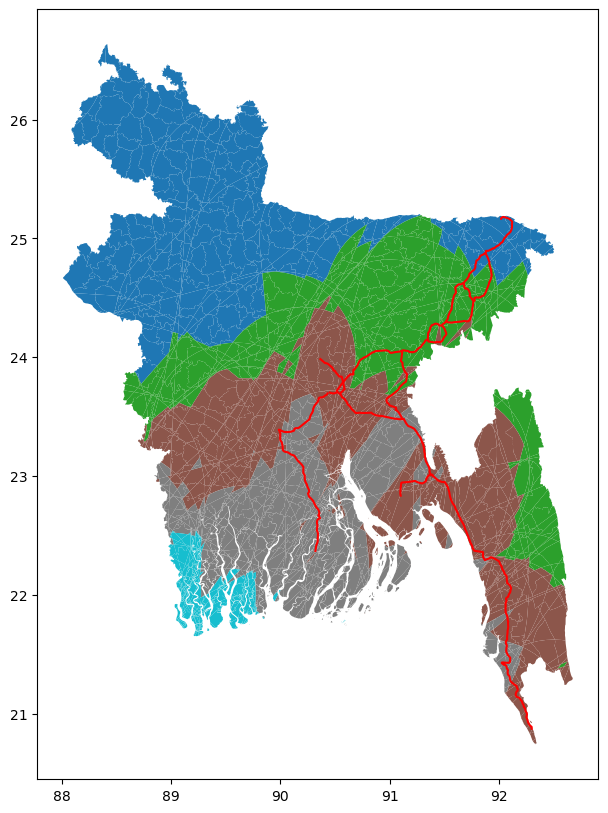

In [186]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
flood_map.plot(ax=ax,column="CycloonCat")
lines_N.plot(ax=ax,color="red")

<AxesSubplot:>

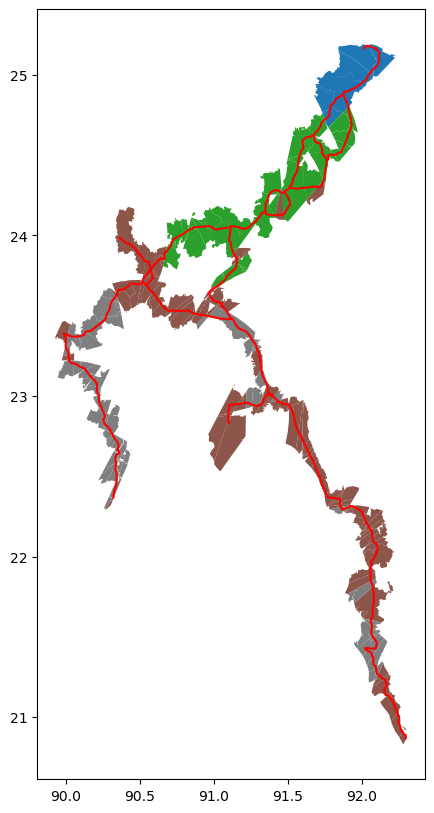

In [187]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
rel_region.plot(ax=ax,column="CycloonCat")
lines_N.plot(ax=ax,color="red")

In [188]:
flood_value =[]
for point_index in gdf_N.index:
    point = gdf_N.loc[point_index,"geometry"]
    region_index =rel_region["geometry"].intersects(point)
    try:
        region = flood_map[flood_map.index.isin(region_index[region_index.values].index)].head(1)["CycloonCat"].values[0]
        flood_value.append(region)
    except:   
        flood_value.append(0)
gdf_N["CycloonCat"] = flood_value

In [189]:
gdf_N

,Unnamed: 0.1,Unnamed: 0,index,road,km,type,name,length,condition,lat,lon,model_type,geometry,FLOODCAT,FloodImpact,CycloonCat
0,0,0,0,N1,0.000,sourcesink,sourcesink,0.0,NaN,23.706028,90.443333,sourcesink,POINT (90.44333 23.70603),0,1.0,2
1,1,1,0,N1,1.800,Box Culvert,.,11.3,A,23.698739,90.458861,bridge,POINT (90.45886 23.69874),0,1.0,2
2,2,2,1,N1,4.925,Box Culvert,.,6.6,A,23.694664,90.487775,bridge,POINT (90.48777 23.69466),0,1.0,2
3,3,3,2,N1,8.976,PC Girder Bridge,KANCHPUR PC GIRDER BRIDGE,397.0,C,23.705060,90.523214,bridge,POINT (90.52321 23.70506),0,1.0,2
4,4,4,3,N1,10.543,Box Culvert,KATCHPUR BOX CULVERT,8.0,B,23.696400,90.535099,bridge,POINT (90.53510 23.69640),0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683,3602,3602,3444,N8,197.979,Box Culvert,.,5.1,A,22.420795,90.329901,bridge,POINT (90.32990 22.42079),8,1.4,3
1684,3603,3603,3445,N8,198.564,Box Culvert,.,10.1,A,22.415863,90.328483,bridge,POINT (90.32848 22.41586),8,1.4,3
1685,3604,3604,3446,N8,198.955,RCC Girder Bridge,Sheyalir Bridge,13.0,A,22.412348,90.327632,bridge,POINT (90.32763 22.41235),8,1.4,3
1686,3605,3605,3447,N8,199.222,Baily with Steel Deck,.,21.3,C,22.410058,90.326723,bridge,POINT (90.32672 22.41006),8,1.4,3


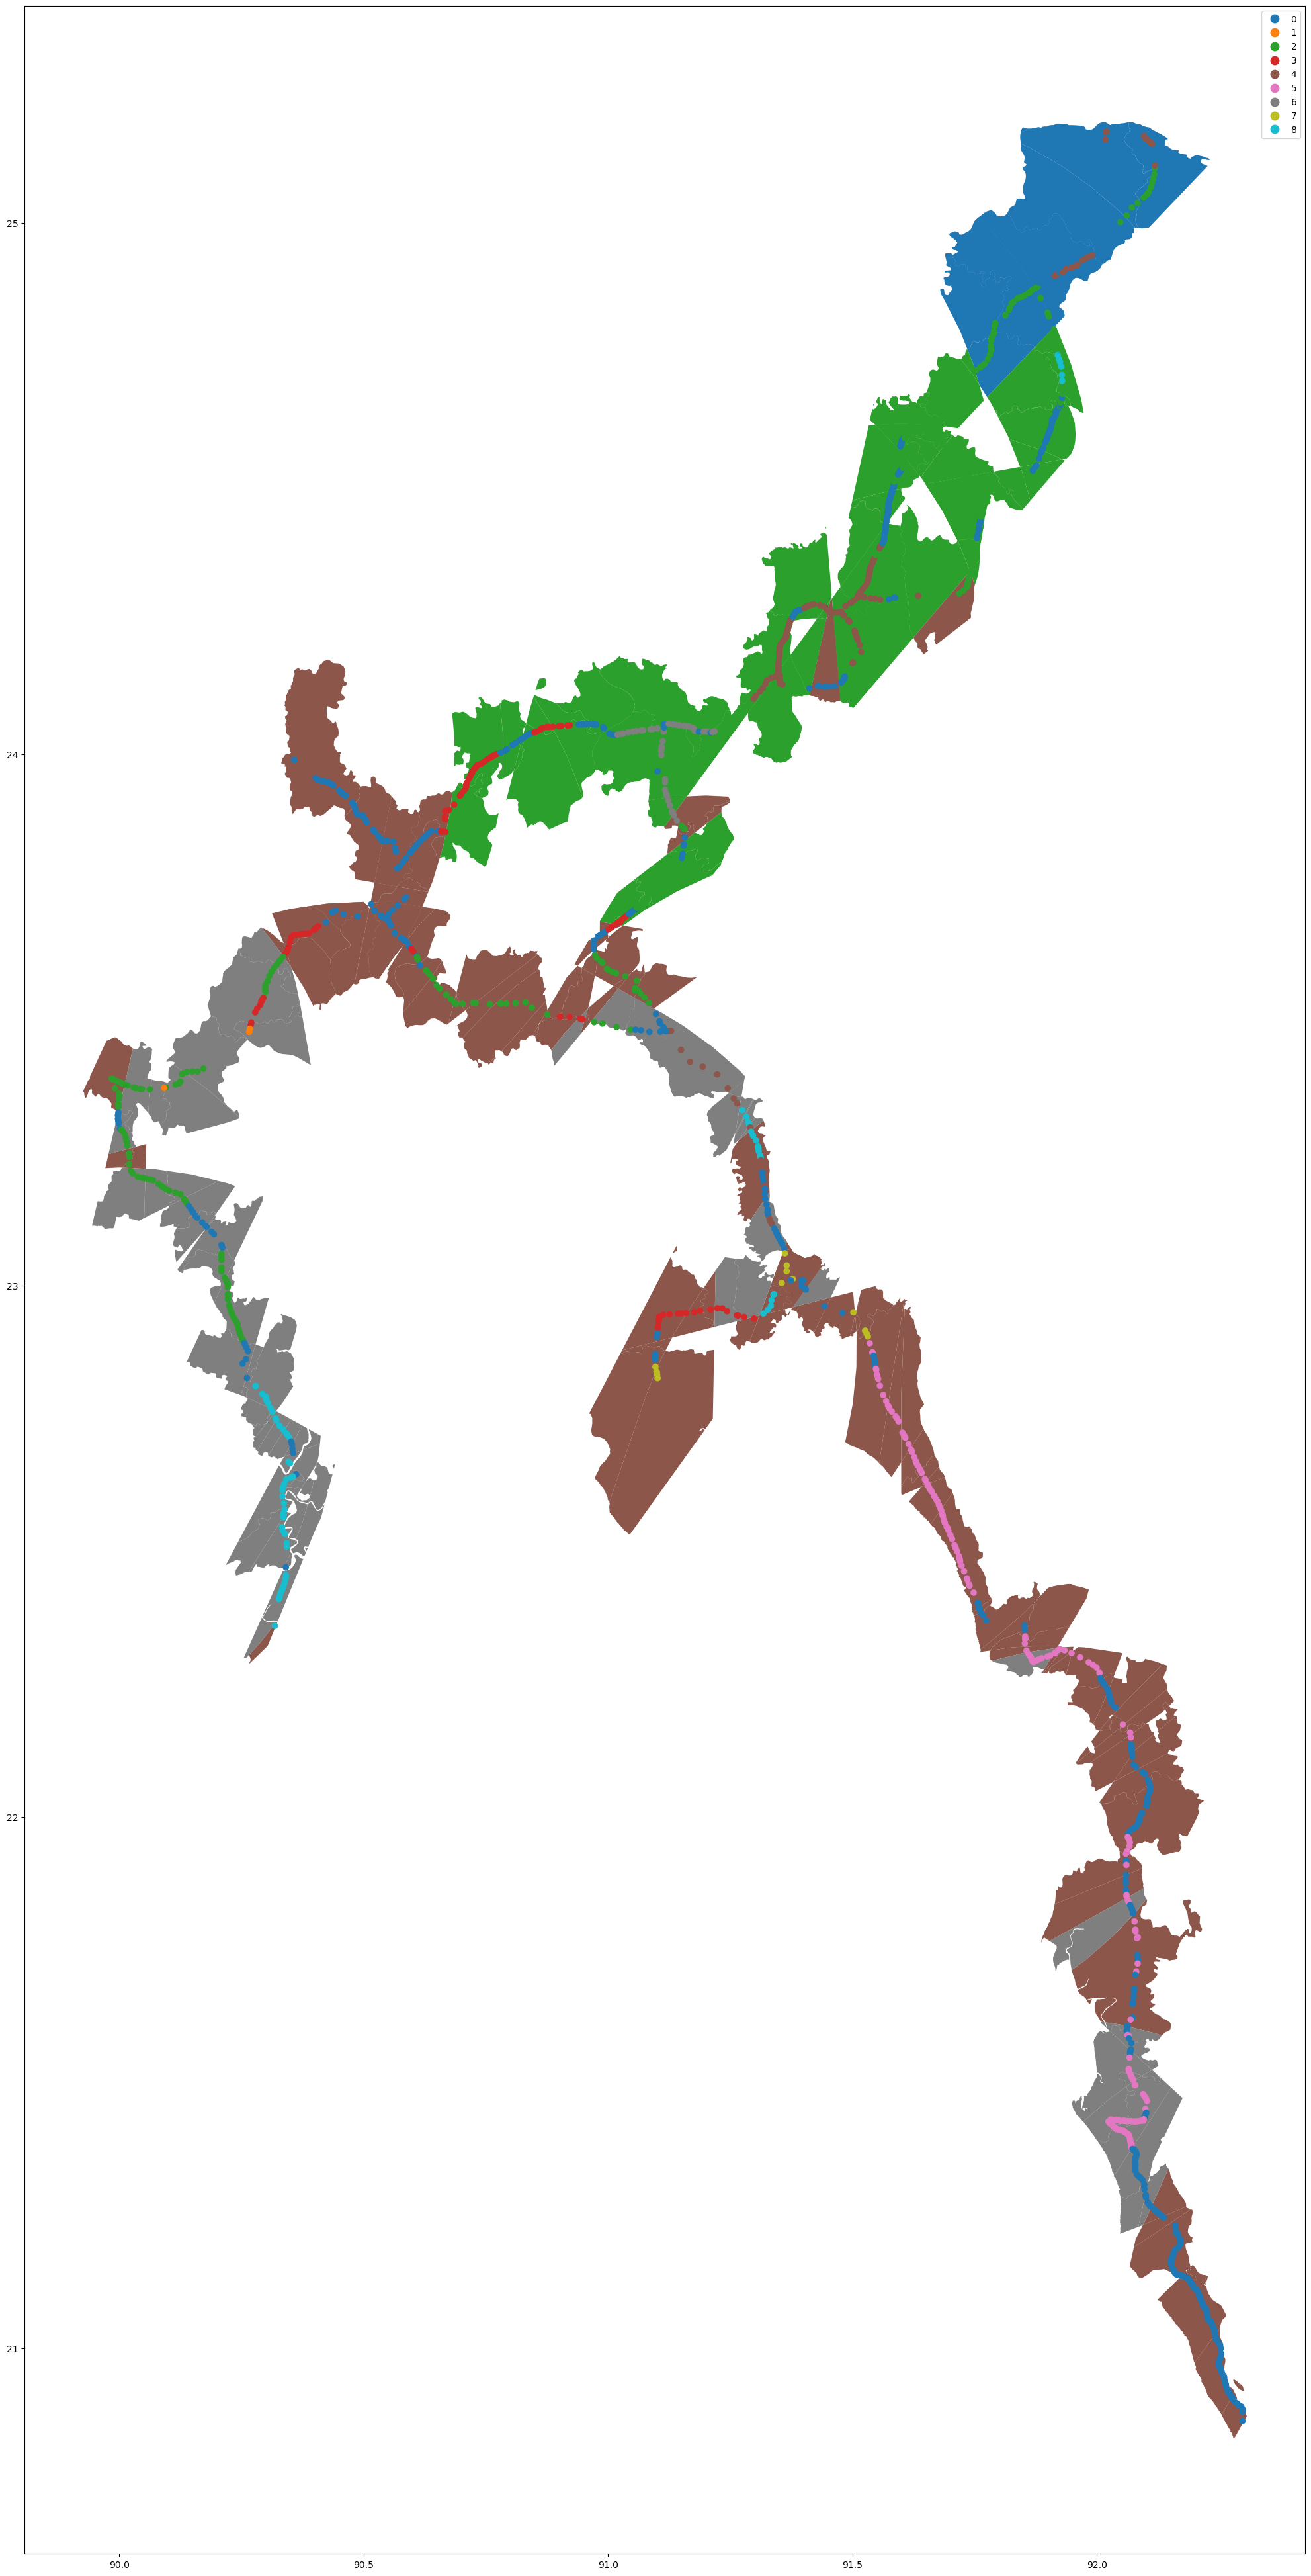

In [190]:
fig,ax=plt.subplots(1,1,figsize=(50,50))
rel_region.plot(ax=ax,column="CycloonCat")
gdf_N.plot(ax=ax,column="FLOODCAT",categorical=True,legend=True)
plt.show()

In [191]:
import numpy as np

In [192]:
gdf_N.CycloonCat.unique()

array(['2', '3', '1', '0'], dtype=object)

In [193]:
cycloon_impact_weight =dict(zip(np.sort(gdf_N.CycloonCat.unique()),np.arange(0.0, 0.5, 0.13333333333)))

In [194]:
gdf_N["CycloonImpact"] = gdf_N["CycloonCat"].map(cycloon_impact_weight) 
gdf_N["CycloonImpact"] = gdf_N["CycloonImpact"] +1


In [195]:
gdf_N["Combi"] = gdf_N["CycloonImpact"]*gdf_N["FLOODCAT"]

In [196]:
gdf_N.to_csv(main_folder_path + "/data/bridges_cleaned_maps.csv")